# 1. Introduction


In [ ]:
!pip install imutils

In [23]:
from imutils.object_detection import non_max_suppression
import typing
import string

import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import glob
import os
import time
import hashlib

import urllib.request
import urllib.parse

tf.__version__

'2.6.2'

# 2. Train Detector Model

In [ ]:
dataset_path = 'represent_data/'
def representative_data_gen():
    for file in os.listdir(dataset_path):
        image_path = dataset_path + file
        input_data = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        input_data = cv2.resize(input_data, (200, 31))
        input_data = input_data[np.newaxis]
        input_data = np.expand_dims(input_data, 3)
        input_data = input_data.astype('float32')/255
        yield [input_data]

# 3. Load from previous trained model

## 3.1 Create representative set

In order to use integer quantization we need a representative dataset. We will be using the COCO-Text dataset for this purpose. As the dataset is pretty heavy in size, I have prepapred a small subset of it by sampling 100 training images randomly.

In [3]:
# Download data
!wget -q https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/releases/download/v0.11.0/coco_text_100.tar.gz
!tar xf coco_text_100.tar.gz

In [6]:
# Create example array of images
IMAGE_LIST = list(glob.glob("coco_text_100/*.jpg"))
IMG_SIZE = 320

def representative_dataset_gen():
    for image_path in IMAGE_LIST:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image.astype("float32")
        mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
        image -= mean
        image = np.expand_dims(image, axis=0)
        yield [image]

## 3.2 OpenCV Text Detection (EAST text detector)

In [2]:
!wget -q https://github.com/dilhelh/opencv-text-detection/archive/refs/heads/master.zip
!unzip -qq master.zip

In [7]:
def convert_detect_tflite(quantization):
    converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
        graph_def_file='opencv-text-detection-master/frozen_east_text_detection.pb', 
        input_arrays=['input_images'],
        output_arrays=['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3'],
        input_shapes={'input_images': [1, 320, 320, 3]}
    )

    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    if quantization=="float64":
        converter.target_spec.supported_types = [tf.float64]
    elif quantization=="float16":
        converter.target_spec.supported_types = [tf.float16]
    elif quantization=="int8":
        converter.representative_dataset = representative_dataset_gen
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8

    tflite_model = converter.convert()
    open('detect_{}.tflite'.format(quantization), 'wb').write(tflite_model)

In [8]:
convert_detect_tflite("float64")
convert_detect_tflite("float16")
convert_detect_tflite("int8")

In [15]:
!du -h detect_*.tflite

46M	detect_float16.tflite
92M	detect_float64.tflite
24M	detect_int8.tflite


# 4. Convert model to tflite

This takes a tf model and converts the types. For example, it can change doubles to float which will reduce the size of the model by 50%. If doubles are converted to int8, it can reduce the size of the model to 25%.


In [ ]:
def convert_tflite(model, name, quantization):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_ops = [
      tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
      tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
    ]
    if quantization == 'float16':
        converter.target_spec.supported_types = [tf.float16]
    elif quantization == 'int8':
        converter.representative_dataset = representative_data_gen
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8  # or tf.uint8
        converter.inference_output_type = tf.int8  # or tf.uint8
    tf_lite_model = converter.convert()
    open(f'{name}_{quantization}.tflite', 'wb').write(tf_lite_model)

# 5. Convert from tflite to cc array

A tflite file is not runable from ESP32 or other microprocessor. In order to call the model, it needs to be converted to an array to be read in by the tflite libraries.

xxd converts the model to a hex representation.

In [ ]:
!xxd -i recognize_float16.tflite > recognize_float16.cc

In [33]:
!xxd -i detect_float64.tflite > detect_float64.cc
!xxd -i detect_float16.tflite > detect_float16.cc
!xxd -i detect_int8.tflite > detect_int8.cc

In [34]:
!du -h detect_*.cc

284M	detect_float16.cc
566M	detect_float64.cc
146M	detect_int8.cc


# 6. Test model with real examples

Test with some example images. They need to be preprocessed to update size and then run through model.

In [37]:
def preprocess_image(image_path):
    # load the input image and grab the image dimensions
    image = cv2.imread(image_path)
    orig = image.copy()
    (H, W) = image.shape[:2]
    
    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    plt.imshow(image)
    # convert the image to a floating point data type and perform mean
    # subtraction
    image = image.astype("float32")
    mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
    image -= mean
    image = np.expand_dims(image, 0)
    return image, orig, rW, rH

In [38]:
def perform_inference(tflite_path, preprocessed_image):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    input_details = interpreter.get_input_details()
    
    if input_details[0]["dtype"]==np.uint8:
        print("Integer quantization!")
        input_scale, input_zero_point = input_details[0]["quantization"]
        preprocessed_image = preprocessed_image / input_scale + input_zero_point
    preprocessed_image = preprocessed_image.astype(input_details[0]["dtype"])
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)

    start = time.time()
    interpreter.invoke()
    print(f"Inference took: {time.time()-start} seconds")

    scores = interpreter.tensor(
        interpreter.get_output_details()[0]['index'])()
    geometry = interpreter.tensor(
        interpreter.get_output_details()[1]['index'])()

    return scores, geometry

In [43]:
def post_process(score, geo, ratioW, ratioH, original):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.5:
                continue
            print("HERE")
            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * ratioW)
        startY = int(startY * ratioH)
        endX = int(endX * ratioW)
        endY = int(endY * ratioH)

        # draw the bounding box on the image
        cv2.rectangle(original, (startX, startY), (endX, endY), (0, 255, 0), 2)

    # show the output image
    plt.imshow(original)

Inference took: 0.5356948375701904 seconds


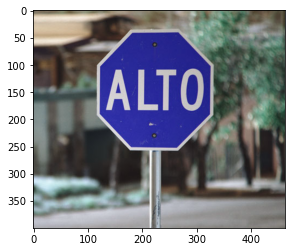

In [44]:
# Test detect
test_image = "opencv-text-detection-master/images/sign.jpg"
quantization = "float64" #@param ["float64", "float16", "int8"]
image, orig, rW, rH = preprocess_image(test_image)
scores, geometry = perform_inference(tflite_path=f'detect_{quantization}.tflite',
                                     preprocessed_image=image)
post_process(scores, geometry, rW, rH, orig)